In [20]:
import pandas as pd 
import numpy as np 
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV
import time
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier




# Task 1

In [45]:
file_path = "renttherunway_final_data.json"
data = pd.read_json(file_path, lines=True)


In [47]:
percentage = (data.isnull().any(axis=1).sum() / len(data)) * 100
print(f"Percentage of rows with at least one null value: {percentage:.2f}%")
data.shape

Percentage of rows with at least one null value: 23.98%


(192544, 15)

In [48]:
data = data.dropna()

In [49]:
data.head(5)

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137lbs,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28.0,"April 20, 2016"
1,fit,273551,34b,153475,132lbs,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36.0,"June 18, 2013"
3,fit,909926,34c,126335,135lbs,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34.0,"February 12, 2014"
4,fit,151944,34b,616682,145lbs,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27.0,"September 26, 2016"
5,fit,734848,32b,364092,138lbs,8.0,date,Didn't actually wear it. It fit perfectly. The...,athletic,Traditional with a touch a sass,dress,"5' 8""",8,45.0,"April 30, 2016"


In [23]:
def clean_weight(weight):
    if isinstance(weight, str):
        return float(weight.replace("lbs", ""))
    return weight

def clean_height(height):
    if isinstance(height, str):
        match = re.match(r"(\d+)' (\d+)\"", height)
        if match:
            feet = int(match.group(1))
            inches = int(match.group(2))
            return feet * 12 + inches
    return height

data["weight"] = data["weight"].apply(clean_weight)
data["height"] = data["height"].apply(clean_height)
data["age"] = pd.to_numeric(data["age"], errors="coerce")

data["weight"].fillna(data["weight"].mean(), inplace=True)
data["bust size"].fillna("Unknown", inplace=True)
data["body type"].fillna("Unknown", inplace=True)

data["review_length"] = data["review_text"].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)

# data_cleaned = data.drop(columns =["review_date", "age", "rented for", "user_id", "item_id", "review_summary"])
# data_cleaned.head(10)

C:\Users\kanet\AppData\Local\Temp\ipykernel_22604\3599838514.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["weight"].fillna(data["weight"].mean(), inplace=True)
C:\Users\kanet\AppData\Local\Temp\ipykernel_22604\3599838514.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a co

In [24]:
# Basic statistics of numerical columns
print("\nNumerical Column Statistics:")
print(data[["height", "weight", "age", "rating", "size"]].describe())


Numerical Column Statistics:
              height         weight            age         rating  \
count  146381.000000  146381.000000  146381.000000  146381.000000   
mean       65.263053     137.209870      34.089800       9.081985   
std         2.659230      21.540182       8.113217       1.437853   
min        54.000000      50.000000       0.000000       2.000000   
25%        63.000000     123.000000      29.000000       8.000000   
50%        65.000000     135.000000      32.000000      10.000000   
75%        67.000000     148.000000      37.000000      10.000000   
max        78.000000     300.000000     117.000000      10.000000   

                size  
count  146381.000000  
mean       11.437919  
std         7.826784  
min         0.000000  
25%         4.000000  
50%         9.000000  
75%        16.000000  
max        58.000000  


In [25]:
# Distribution of fit categories
print("\nFit Distribution:")
print(data["fit"].value_counts(normalize=True) * 100)


Fit Distribution:
fit
fit      73.597666
small    13.404745
large    12.997588
Name: proportion, dtype: float64


In [26]:
# Distribution of categories
print("\nTop 10 Clothing Categories:")
print(data["category"].value_counts().head(10))


Top 10 Clothing Categories:
category
dress       70474
gown        33278
sheath      14691
shift        4039
jumpsuit     4019
top          3780
maxi         2600
romper       2447
jacket       1871
mini         1417
Name: count, dtype: int64


In [27]:
# Distribution of body types
print("\nBody Type Distribution:")
print(data["body type"].value_counts())


Body Type Distribution:
body type
hourglass            43982
athletic             37518
petite               19358
pear                 18051
straight & narrow    12866
full bust            10797
apple                 3809
Name: count, dtype: int64


In [28]:
# Average ratings by fit
print("\nAverage Rating by Fit:")
print(data.groupby("fit")["rating"].mean())


Average Rating by Fit:
fit
fit      9.301774
large    8.517187
small    8.422893
Name: rating, dtype: float64


In [29]:
# Correlation analysis for numerical features
numerical_cols = ["height", "weight", "age", "rating", "size", "review_length"]
correlation_matrix = data[numerical_cols].corr()
print("\nCorrelation Matrix:")
print(correlation_matrix)


Correlation Matrix:
                 height    weight       age    rating      size  review_length
height         1.000000  0.392010 -0.001849  0.004351  0.243473       0.007633
weight         0.392010  1.000000  0.061518 -0.023085  0.845170       0.035964
age           -0.001849  0.061518  1.000000 -0.030429  0.168706      -0.095468
rating         0.004351 -0.023085 -0.030429  1.000000 -0.037206      -0.012664
size           0.243473  0.845170  0.168706 -0.037206  1.000000       0.032739
review_length  0.007633  0.035964 -0.095468 -0.012664  0.032739       1.000000


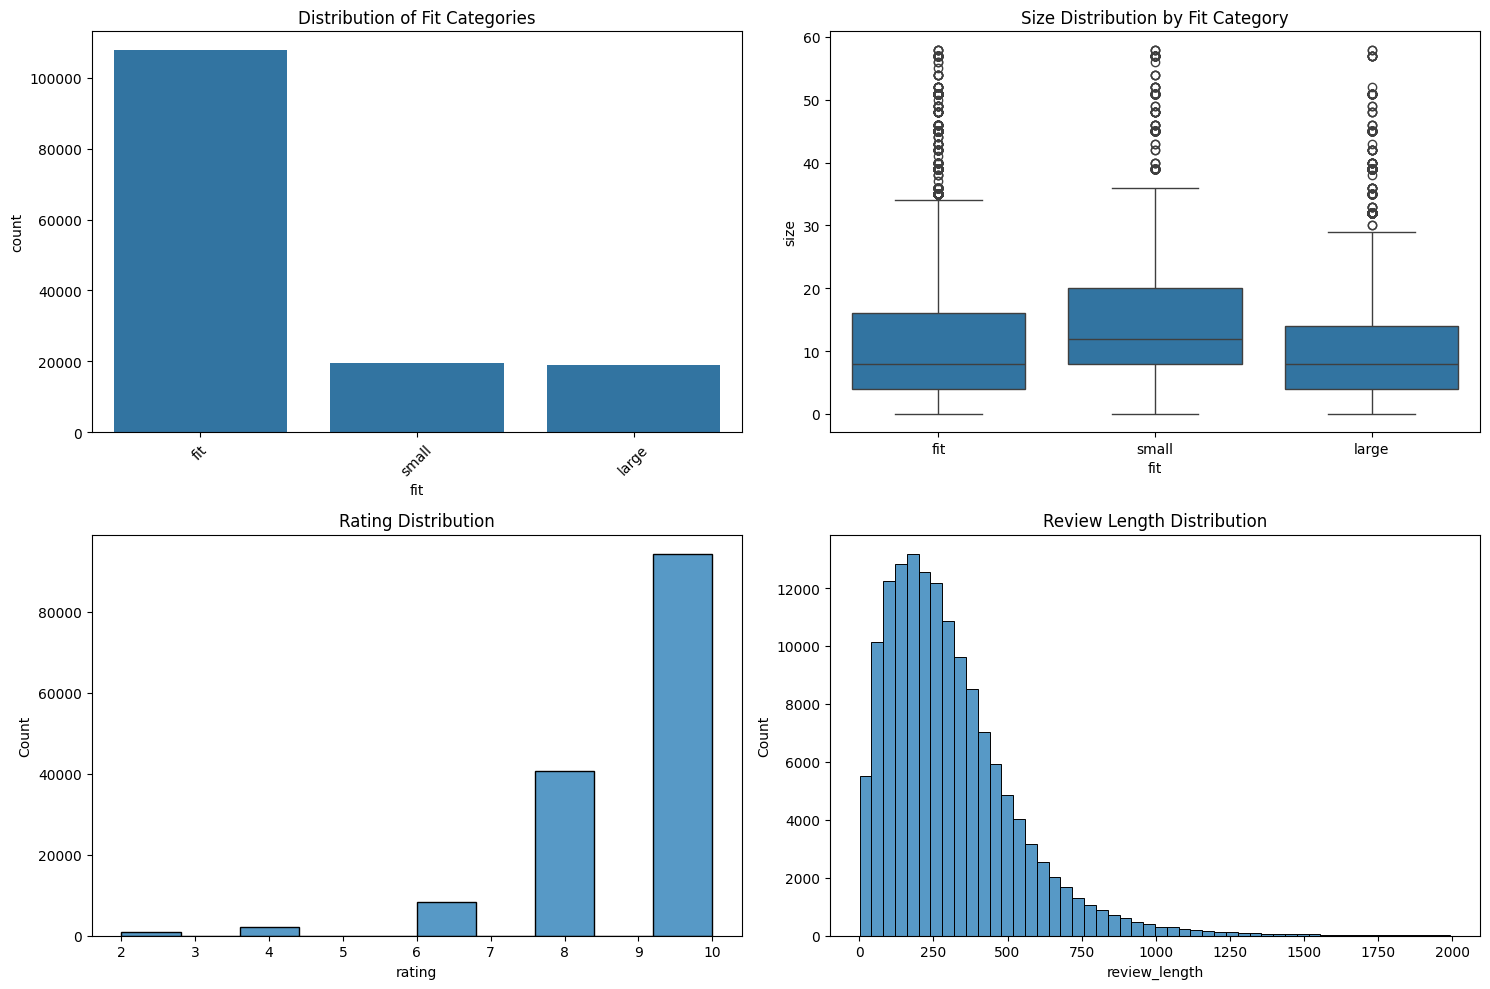

In [30]:
# Visualization of key distributions
plt.figure(figsize=(15, 10))

# Plot 1: Distribution of Fit
plt.subplot(2, 2, 1)
sns.countplot(data=data, x="fit")
plt.title("Distribution of Fit Categories")
plt.xticks(rotation=45)

# Plot 2: Box plot of Size by Fit
plt.subplot(2, 2, 2)
sns.boxplot(data=data, x="fit", y="size")
plt.title("Size Distribution by Fit Category")

# Plot 3: Rating Distribution
plt.subplot(2, 2, 3)
sns.histplot(data=data, x="rating", bins=10)
plt.title("Rating Distribution")

# Plot 4: Review Length Distribution
plt.subplot(2, 2, 4)
sns.histplot(data=data, x="review_length", bins=50)
plt.title("Review Length Distribution")

plt.tight_layout()
plt.show()


In [31]:
# Additional analysis for size and measurements
print("\nSize Distribution by Category:")
size_category = pd.crosstab(data["size"], data["category"])
print(size_category)

# Analyze review text patterns
print("\nAverage Review Length by Fit:")
print(data.groupby("fit")["review_length"].mean())


Size Distribution by Category:
category  ballgown  blazer  blouse  blouson  bomber  buttondown  caftan  cami  \
size                                                                            
0                0       0       0        0       0           0       0     0   
1                0      60      18        3       5           0       0     1   
2                0       1       1        0       0           0       0     0   
3                0       0       0        0       0           0       0     0   
4                0     120      80        0      15           0       1     4   
5                0       0       0        0       0           0       0     0   
6                0       0       0        0       0           0       0     0   
7                0       0       0        0       0           0       0     0   
8                0     160     154        3      33           0       2     3   
9                0       0       0        0       0           0       0     0

### Generate Cleaned CSV

In [32]:
# Save cleaned data for next steps
data_cleaned = data.drop(columns=["review_date", "age", "rented for", "user_id", "item_id"])
data_cleaned.to_csv("cleaned_rtr_data.csv", index=False)

C:\Users\kanet\AppData\Local\Temp\ipykernel_22604\4053501243.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data_cleaned, x="fit", palette="viridis")


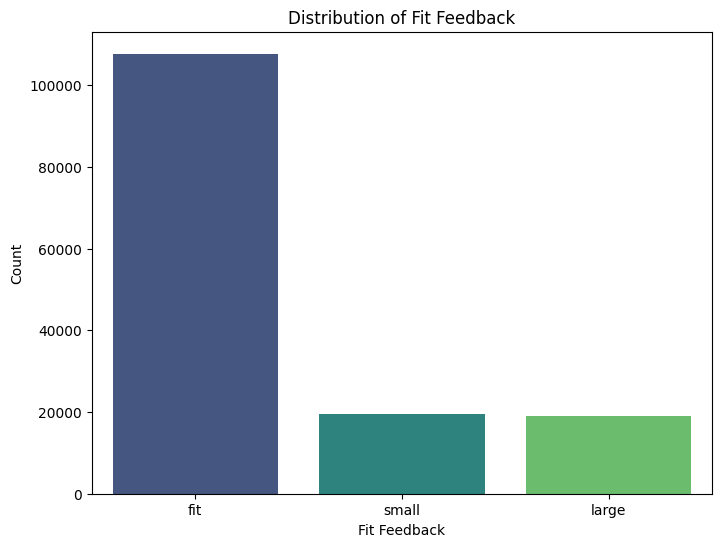

In [33]:
# Distribution of Fit Feedback
plt.figure(figsize=(8, 6))
sns.countplot(data=data_cleaned, x="fit", palette="viridis")
plt.title("Distribution of Fit Feedback")
plt.xlabel("Fit Feedback")
plt.ylabel("Count")
plt.show()



C:\Users\kanet\AppData\Local\Temp\ipykernel_22604\384280098.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data_cleaned, x="fit", y="weight", palette="pastel")


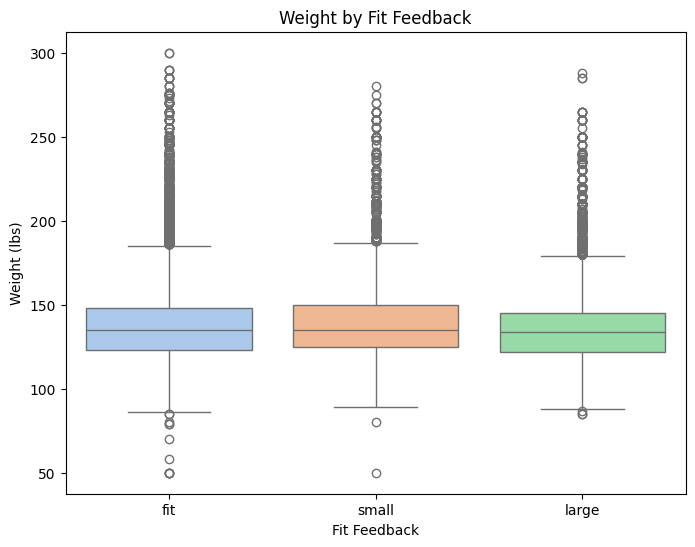

In [34]:
# Weight by Fit Feedback
plt.figure(figsize=(8, 6))
sns.boxplot(data=data_cleaned, x="fit", y="weight", palette="pastel")
plt.title("Weight by Fit Feedback")
plt.xlabel("Fit Feedback")
plt.ylabel("Weight (lbs)")
plt.show()



C:\Users\kanet\AppData\Local\Temp\ipykernel_22604\1708035660.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data_cleaned, x="fit", y="height", palette="coolwarm")


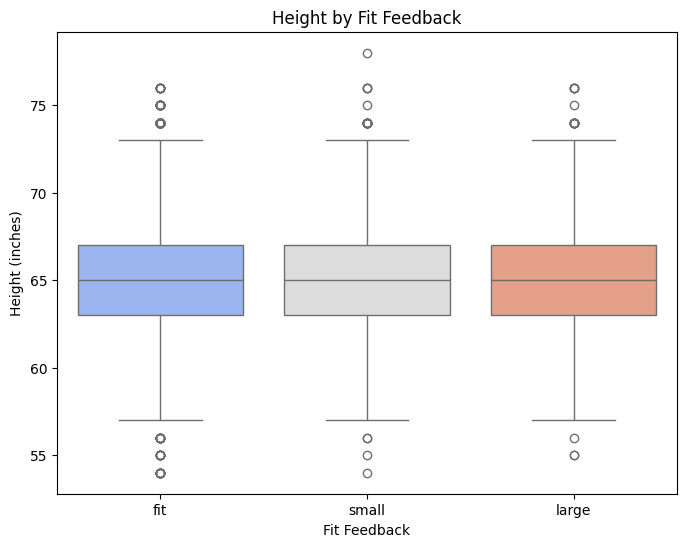

In [35]:
# Height by Fit Feedback
plt.figure(figsize=(8, 6))
sns.boxplot(data=data_cleaned, x="fit", y="height", palette="coolwarm")
plt.title("Height by Fit Feedback")
plt.xlabel("Fit Feedback")
plt.ylabel("Height (inches)")
plt.show()



C:\Users\kanet\AppData\Local\Temp\ipykernel_22604\138995026.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data_cleaned, x="fit", y="review_length", palette="Blues")


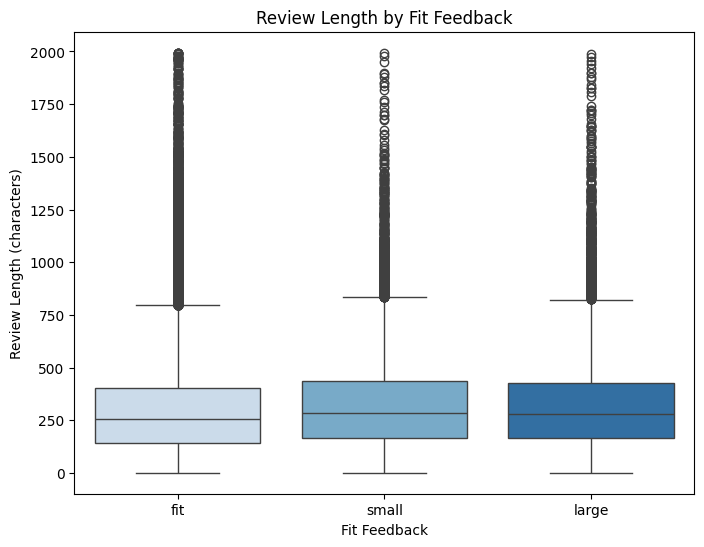

In [36]:
# Review Length by Fit Feedback
plt.figure(figsize=(8, 6))
sns.boxplot(data=data_cleaned, x="fit", y="review_length", palette="Blues")
plt.title("Review Length by Fit Feedback")
plt.xlabel("Fit Feedback")
plt.ylabel("Review Length (characters)")
plt.show()

# Task 2

### Base Model

In [37]:

# Load the cleaned data
data = pd.read_csv("cleaned_rtr_data.csv")

# Define the prediction task
print("Prediction Task: Predict clothing fit (fit/small/large) based on user measurements and review data")
print("\nTarget Variable Distribution:")
print(data["fit"].value_counts(normalize=True))

# Feature Engineering

# 1. Process bust size
def process_bust_size(bust):
    if pd.isna(bust) or bust == "Unknown":
        return None, None
    match = re.match(r"(\d+)([A-Za-z]+)", str(bust))
    if match:
        number = int(match.group(1))
        letter = match.group(2).upper()
        letter_value = ord(letter[0]) - ord('A') + 1
        return number, letter_value
    return None, None

data[["bust_number", "bust_letter_value"]] = pd.DataFrame(
    data["bust size"].apply(process_bust_size).tolist(),
    index=data.index
)

# 2. Calculate BMI
data["bmi"] = (data["weight"] * 703) / (data["height"] ** 2)

# 3. Process categories
label_encoder = LabelEncoder()
data["category_encoded"] = label_encoder.fit_transform(data["category"])
category_dummies = pd.get_dummies(data["category"], prefix="category")

# 4. Process body types
body_type_dummies = pd.get_dummies(data["body type"], prefix="body_type")

# 5. Text feature engineering
# Basic text features
data["review_word_count"] = data["review_text"].fillna("").str.split().str.len()
data["review_avg_word_length"] = data["review_text"].fillna("").apply(
    lambda x: np.mean([len(word) for word in str(x).split()]) if len(str(x)) > 0 else 0
)

# TF-IDF for review text
tfidf = TfidfVectorizer(
    max_features=100,  # Adjust based on your needs
    stop_words='english',
    ngram_range=(1, 2)
)
review_tfidf = tfidf.fit_transform(data["review_text"].fillna(""))
tfidf_df = pd.DataFrame(
    review_tfidf.toarray(),
    columns=[f"tfidf_{i}" for i in range(review_tfidf.shape[1])]
)

# Combine all features
feature_columns = [
    # Numerical features
    "height", "weight", "bmi", "size",
    "bust_number", "bust_letter_value",
    "review_length", "review_word_count", "review_avg_word_length",
    "rating"
]

# Create final feature matrix
X = pd.concat([
    data[feature_columns],
    category_dummies,
    body_type_dummies,
    tfidf_df
], axis=1)

# Target variable
y = data["fit"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale numerical features
numerical_features = feature_columns
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test_scaled[numerical_features] = scaler.transform(X_test[numerical_features])

# Print feature information
print("\nFinal Feature Set:")
print(f"Total number of features: {X.shape[1]}")
print("\nFeature categories:")
print(f"- Numerical features: {len(numerical_features)}")
print(f"- Category features: {len(category_dummies.columns)}")
print(f"- Body type features: {len(body_type_dummies.columns)}")
print(f"- Text features: {review_tfidf.shape[1]}")

# Save processed data for modeling
X_train_scaled.to_csv("X_train.csv", index=False)
X_test_scaled.to_csv("X_test.csv", index=False)
pd.Series(y_train).to_csv("y_train.csv", index=False)
pd.Series(y_test).to_csv("y_test.csv", index=False)

# Print evaluation strategy
print("\nEvaluation Strategy:")
print("- Metrics to be used: Accuracy, Precision, Recall, F1-Score")
print("- Stratified K-fold cross-validation will be used")
print("- Separate test set held out for final evaluation")
print(f"- Training set size: {len(X_train)}")
print(f"- Test set size: {len(X_test)}")

# Print baseline metrics
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train_scaled, y_train)
print("\nBaseline (Most Frequent Class) Accuracy:", 
      dummy.score(X_test_scaled, y_test))

Prediction Task: Predict clothing fit (fit/small/large) based on user measurements and review data

Target Variable Distribution:
fit
fit      0.735977
small    0.134047
large    0.129976
Name: proportion, dtype: float64

Final Feature Set:
Total number of features: 185

Feature categories:
- Numerical features: 10
- Category features: 68
- Body type features: 7
- Text features: 100

Evaluation Strategy:
- Metrics to be used: Accuracy, Precision, Recall, F1-Score
- Stratified K-fold cross-validation will be used
- Separate test set held out for final evaluation
- Training set size: 117104
- Test set size: 29277

Baseline (Most Frequent Class) Accuracy: 0.7359702155275473


### Random Forest

In [20]:
# Load the preprocessed data
X_train = pd.read_csv("X_train.csv")
X_test = pd.read_csv("X_test.csv")
y_train = pd.read_csv("y_train.csv").values.ravel()
y_test = pd.read_csv("y_test.csv").values.ravel()

# Initialize and train Random Forest
start_time = time.time()

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

# Train the model
rf_model.fit(X_train, y_train)
training_time = time.time() - start_time

# Make predictions
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)

# Get confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Get classification report
class_report = classification_report(y_test, y_pred, output_dict=True)

# Get cross-validation scores
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5)

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Save all the detailed metrics and model
detailed_metrics = {
    'model_type': 'Random Forest',
    'accuracy': cv_scores.mean(),
    'std_dev': cv_scores.std(),
    'training_time': training_time,
    'top_features': feature_importance.head(5)['feature'].tolist(),
    'confusion_matrix': conf_matrix,
    'confusion_matrix_normalized': conf_matrix_normalized,
    'classification_report': class_report,
    'cv_scores': cv_scores,
    'feature_importance': feature_importance,
    'predictions': y_pred,
    'probabilities': y_prob
}

# Save detailed metrics
with open('rf_detailed_metrics.pkl', 'wb') as f:
    pickle.dump(detailed_metrics, f)

# Save the model itself
with open('rf_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

# Print immediate results
print("\nRandom Forest Model Results")
print("-" * 50)
print(f"\nTraining time: {training_time:.2f} seconds")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nCross-validation scores:", cv_scores)
print(f"Average CV score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))


Random Forest Model Results
--------------------------------------------------

Training time: 3.20 seconds

Classification Report:
              precision    recall  f1-score   support

         fit       0.76      1.00      0.86     28412
       large       0.87      0.13      0.23      4941
       small       0.91      0.13      0.22      5156

    accuracy                           0.77     38509
   macro avg       0.85      0.42      0.44     38509
weighted avg       0.80      0.77      0.70     38509


Confusion Matrix:
[[28299    68    45]
 [ 4258   666    17]
 [ 4467    32   657]]

Cross-validation scores: [0.76716331 0.76885124 0.77037686 0.77005226 0.7695329 ]
Average CV score: 0.769 (+/- 0.002)

Top 10 Most Important Features:
      feature  importance
167  tfidf_81    0.137277
133  tfidf_47    0.125780
163  tfidf_77    0.112350
9      rating    0.091887
94    tfidf_8    0.077099
174  tfidf_88    0.048328
171  tfidf_85    0.048300
165  tfidf_79    0.047297
173  tfidf_87    

### XGBoost

In [38]:
# Load the preprocessed data
X_train = pd.read_csv("X_train.csv")
X_test = pd.read_csv("X_test.csv")
y_train = pd.read_csv("y_train.csv").values.ravel()
y_test = pd.read_csv("y_test.csv").values.ravel()

# Encode the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Initialize and train XGBoost
start_time = time.time()

xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# Train the model
xgb_model.fit(X_train, y_train_encoded)
training_time = time.time() - start_time

# Make predictions
y_pred_encoded = xgb_model.predict(X_test)
y_pred = label_encoder.inverse_transform(y_pred_encoded)
y_prob = xgb_model.predict_proba(X_test)

# Get confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Get classification report
class_report = classification_report(y_test, y_pred, output_dict=True)

# Get cross-validation scores
cv_scores = cross_val_score(xgb_model, X_train, y_train_encoded, cv=5)

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Save all the detailed metrics and model
detailed_metrics = {
    'model_type': 'XGBoost',
    'accuracy': cv_scores.mean(),
    'std_dev': cv_scores.std(),
    'training_time': training_time,
    'top_features': feature_importance.head(5)['feature'].tolist(),
    'confusion_matrix': conf_matrix,
    'confusion_matrix_normalized': conf_matrix_normalized,
    'classification_report': class_report,
    'cv_scores': cv_scores,
    'feature_importance': feature_importance,
    'predictions': y_pred,
    'probabilities': y_prob,
    'label_mapping': dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
}

# Save detailed metrics
with open('xgb_detailed_metrics.pkl', 'wb') as f:
    pickle.dump(detailed_metrics, f)

# Save the model
with open('xgb_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

# Save label encoder
with open('xgb_label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

# Print immediate results
print("\nXGBoost Model Results")
print("-" * 50)
print(f"\nTraining time: {training_time:.2f} seconds")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nCross-validation scores:", cv_scores)
print(f"Average CV score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))


XGBoost Model Results
--------------------------------------------------

Training time: 4.64 seconds

Classification Report:
              precision    recall  f1-score   support

         fit       0.81      0.96      0.88     21547
       large       0.74      0.35      0.47      3805
       small       0.70      0.35      0.47      3925

    accuracy                           0.80     29277
   macro avg       0.75      0.56      0.61     29277
weighted avg       0.79      0.80      0.77     29277


Confusion Matrix:
[[20712   374   461]
 [ 2351  1329   125]
 [ 2433   100  1392]]

Cross-validation scores: [0.80171641 0.80060629 0.80483327 0.79561078 0.80264731]
Average CV score: 0.801 (+/- 0.006)

Top 10 Most Important Features:
      feature  importance
131  tfidf_46    0.066905
161  tfidf_76    0.059650
173  tfidf_88    0.053744
166  tfidf_81    0.048955
93    tfidf_8    0.047693
9      rating    0.044247
170  tfidf_85    0.030789
172  tfidf_87    0.019898
164  tfidf_79    0.0193

In [43]:
#output all of the features in feature_importance
print(feature_importance.to_markdown())

|     | feature                     |   importance |
|----:|:----------------------------|-------------:|
| 131 | tfidf_46                    |  0.0669051   |
| 161 | tfidf_76                    |  0.0596501   |
| 173 | tfidf_88                    |  0.0537436   |
| 166 | tfidf_81                    |  0.048955    |
|  93 | tfidf_8                     |  0.047693    |
|   9 | rating                      |  0.0442465   |
| 170 | tfidf_85                    |  0.0307888   |
| 172 | tfidf_87                    |  0.0198983   |
| 164 | tfidf_79                    |  0.0193039   |
| 167 | tfidf_82                    |  0.0171596   |
| 174 | tfidf_89                    |  0.016694    |
|   3 | size                        |  0.0164644   |
|  20 | category_coat               |  0.0119914   |
|  55 | category_sheath             |  0.0107158   |
|  30 | category_gown               |  0.010283    |
|  77 | category_vest               |  0.00964541  |
|  25 | category_down               |  0.00899

### Logistic Regression

In [21]:
# Load the preprocessed data
X_train = pd.read_csv("X_train.csv")
X_test = pd.read_csv("X_test.csv")
y_train = pd.read_csv("y_train.csv").values.ravel()
y_test = pd.read_csv("y_test.csv").values.ravel()

# Handle NaN values
imputer = SimpleImputer(strategy='mean')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Initialize and train Logistic Regression
start_time = time.time()

lr_model = LogisticRegression(
    max_iter=1000,
    multi_class='multinomial',
    random_state=42,
    n_jobs=-1
)

# Train the model
lr_model.fit(X_train_imputed, y_train)
training_time = time.time() - start_time

# Make predictions
y_pred = lr_model.predict(X_test_imputed)
y_prob = lr_model.predict_proba(X_test_imputed)

# Get confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Get classification report
class_report = classification_report(y_test, y_pred, output_dict=True)

# Get cross-validation scores
cv_scores = cross_val_score(lr_model, X_train_imputed, y_train, cv=5)

# Feature importance (using absolute values of coefficients)
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': np.mean(np.abs(lr_model.coef_), axis=0)
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Save all the detailed metrics and model
detailed_metrics = {
    'model_type': 'Logistic Regression',
    'accuracy': cv_scores.mean(),
    'std_dev': cv_scores.std(),
    'training_time': training_time,
    'top_features': feature_importance.head(5)['feature'].tolist(),
    'confusion_matrix': conf_matrix,
    'confusion_matrix_normalized': conf_matrix_normalized,
    'classification_report': class_report,
    'cv_scores': cv_scores,
    'feature_importance': feature_importance,
    'predictions': y_pred,
    'probabilities': y_prob
}

# Save detailed metrics
with open('lr_detailed_metrics.pkl', 'wb') as f:
    pickle.dump(detailed_metrics, f)

# Save the model
with open('lr_model.pkl', 'wb') as f:
    pickle.dump(lr_model, f)

# Save imputer
with open('lr_imputer.pkl', 'wb') as f:
    pickle.dump(imputer, f)

# Print immediate results
print("\nLogistic Regression Model Results")
print("-" * 50)
print(f"\nTraining time: {training_time:.2f} seconds")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nCross-validation scores:", cv_scores)
print(f"Average CV score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

c:\Users\kanet\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\kanet\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\kanet\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\kanet\AppData\Local\Programs\Python\P


Logistic Regression Model Results
--------------------------------------------------

Training time: 16.42 seconds

Classification Report:
              precision    recall  f1-score   support

         fit       0.81      0.95      0.88     28412
       large       0.68      0.33      0.45      4941
       small       0.65      0.35      0.46      5156

    accuracy                           0.79     38509
   macro avg       0.71      0.55      0.59     38509
weighted avg       0.77      0.79      0.77     38509


Confusion Matrix:
[[27063   568   781]
 [ 3082  1635   224]
 [ 3132   195  1829]]

Cross-validation scores: [0.79264453 0.79394294 0.79572824 0.79339111 0.7916058 ]
Average CV score: 0.793 (+/- 0.003)

Top 10 Most Important Features:
            feature  importance
174        tfidf_88    4.362198
133        tfidf_47    2.469905
171        tfidf_85    2.448306
163        tfidf_77    2.430814
94          tfidf_8    2.308143
167        tfidf_81    1.988214
168        tfidf_82 

### SVM

In [22]:
# Load the preprocessed data
X_train = pd.read_csv("X_train.csv")
X_test = pd.read_csv("X_test.csv")
y_train = pd.read_csv("y_train.csv").values.ravel()
y_test = pd.read_csv("y_test.csv").values.ravel()

# Handle NaN values
imputer = SimpleImputer(strategy='mean')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Feature selection to reduce dimensionality
n_features = 100  # Reduce number of features
selector = SelectKBest(f_classif, k=n_features)
X_train_selected = selector.fit_transform(X_train_imputed, y_train)
X_test_selected = selector.transform(X_test_imputed)

# Get selected feature names
selected_features = X_train_imputed.columns[selector.get_support()].tolist()

# Initialize and train Linear SVM
start_time = time.time()

# Base classifier with optimized parameters
base_svm = LinearSVC(
    dual='auto',
    max_iter=1000,
    random_state=42,
    tol=1e-3,  # Increased tolerance for faster convergence
    C=1.0
)

# Use fewer CV folds for calibration
svm_model = CalibratedClassifierCV(base_svm, cv=3)  # Reduced from 5 to 3

# Train the model
svm_model.fit(X_train_selected, y_train)
training_time = time.time() - start_time

# Make predictions
y_pred = svm_model.predict(X_test_selected)
y_prob = svm_model.predict_proba(X_test_selected)

# Get confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Get classification report
class_report = classification_report(y_test, y_pred, output_dict=True)

# Get cross-validation scores (reduced folds)
cv_scores = cross_val_score(svm_model, X_train_selected, y_train, cv=3)

# Feature importance using the base estimator's coefficients
all_coefs = np.zeros((n_features,))
for calibrated_classifier in svm_model.calibrated_classifiers_:
    estimator = calibrated_classifier.estimator
    all_coefs += np.abs(estimator.coef_).mean(axis=0)
all_coefs = all_coefs / len(svm_model.calibrated_classifiers_)

feature_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': all_coefs
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Save all the detailed metrics and model
detailed_metrics = {
    'model_type': 'Linear SVM',
    'accuracy': cv_scores.mean(),
    'std_dev': cv_scores.std(),
    'training_time': training_time,
    'top_features': feature_importance.head(5)['feature'].tolist(),
    'confusion_matrix': conf_matrix,
    'confusion_matrix_normalized': conf_matrix_normalized,
    'classification_report': class_report,
    'cv_scores': cv_scores,
    'feature_importance': feature_importance,
    'predictions': y_pred,
    'probabilities': y_prob
}

# Save detailed metrics
with open('svm_detailed_metrics.pkl', 'wb') as f:
    pickle.dump(detailed_metrics, f)

# Save the model
with open('svm_model.pkl', 'wb') as f:
    pickle.dump(svm_model, f)

# Save imputer and selector
with open('svm_preprocessor.pkl', 'wb') as f:
    pickle.dump({'imputer': imputer, 'selector': selector}, f)

# Print immediate results
print("\nLinear SVM Model Results")
print("-" * 50)
print(f"\nTraining time: {training_time:.2f} seconds")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nCross-validation scores:", cv_scores)
print(f"Average CV score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))


Linear SVM Model Results
--------------------------------------------------

Training time: 16.73 seconds

Classification Report:
              precision    recall  f1-score   support

         fit       0.81      0.96      0.88     28412
       large       0.67      0.32      0.43      4941
       small       0.65      0.34      0.44      5156

    accuracy                           0.79     38509
   macro avg       0.71      0.54      0.58     38509
weighted avg       0.77      0.79      0.76     38509


Confusion Matrix:
[[27142   570   700]
 [ 3138  1566   237]
 [ 3221   202  1733]]

Cross-validation scores: [0.78971662 0.79148895 0.78965819]
Average CV score: 0.790 (+/- 0.002)

Top 10 Most Important Features:
          feature  importance
89       tfidf_88    2.308138
62       tfidf_47    1.374429
81       tfidf_77    1.327455
34        tfidf_8    1.128953
84       tfidf_81    1.030900
87       tfidf_85    0.960578
83       tfidf_79    0.860926
90       tfidf_89    0.655433
85   

### Comparison Analysis

In [23]:
def load_metrics():
    model_files = {
        'Random Forest': 'rf_detailed_metrics.pkl',
        'XGBoost': 'xgb_detailed_metrics.pkl',
        'Logistic Regression': 'lr_detailed_metrics.pkl',
        'Linear SVM': 'svm_detailed_metrics.pkl'
    }
    
    detailed_metrics = {}
    for model_name, file_path in model_files.items():
        try:
            with open(file_path, 'rb') as f:
                detailed_metrics[model_name] = pickle.load(f)
        except FileNotFoundError:
            print(f"Warning: {file_path} not found")
    return detailed_metrics

def print_basic_metrics(metrics):
    print("\nBasic Performance Metrics")
    print("=" * 80)
    
    basic_data = []
    for model_name, metric in metrics.items():
        basic_data.append({
            'Model': model_name,
            'Accuracy': metric['accuracy'],
            'Training Time (s)': metric['training_time'],
            'Std Dev': metric['std_dev']
        })
    
    basic_df = pd.DataFrame(basic_data)
    print(basic_df.to_string(index=False, float_format=lambda x: '{:.3f}'.format(x)))

def print_class_metrics(metrics):
    print("\nPer-Class Performance Metrics")
    print("=" * 80)
    
    classes = ['fit', 'small', 'large']
    for model_name, metric in metrics.items():
        print(f"\n{model_name}:")
        class_metrics = []
        report = metric['classification_report']
        
        for class_name in classes:
            class_metrics.append({
                'Class': class_name,
                'Precision': report[class_name]['precision'],
                'Recall': report[class_name]['recall'],
                'F1-score': report[class_name]['f1-score'],
                'Support': report[class_name]['support']
            })
        
        class_df = pd.DataFrame(class_metrics)
        print(class_df.to_string(index=False, float_format=lambda x: '{:.3f}'.format(x)))

def print_confusion_matrices(metrics):
    print("\nConfusion Matrices (Normalized)")
    print("=" * 80)
    
    for model_name, metric in metrics.items():
        print(f"\n{model_name}:")
        conf_matrix = metric['confusion_matrix_normalized']
        conf_df = pd.DataFrame(
            conf_matrix,
            columns=['Pred: fit', 'Pred: small', 'Pred: large'],
            index=['True: fit', 'True: small', 'True: large']
        )
        print(conf_df.round(3))

def calculate_macro_metrics(metrics):
    print("\nMacro-Averaged Metrics")
    print("=" * 80)
    
    macro_data = []
    for model_name, metric in metrics.items():
        report = metric['classification_report']
        macro_data.append({
            'Model': model_name,
            'Macro Precision': report['macro avg']['precision'],
            'Macro Recall': report['macro avg']['recall'],
            'Macro F1': report['macro avg']['f1-score']
        })
    
    macro_df = pd.DataFrame(macro_data)
    print(macro_df.to_string(index=False, float_format=lambda x: '{:.3f}'.format(x)))

def plot_advanced_metrics(metrics):
    # Create a figure with multiple subplots
    plt.figure(figsize=(20, 15))
    
    # 1. Precision by class for each model
    plt.subplot(2, 2, 1)
    plot_data = []
    for model_name, metric in metrics.items():
        report = metric['classification_report']
        for class_name in ['fit', 'small', 'large']:
            plot_data.append({
                'Model': model_name,
                'Class': class_name,
                'Precision': report[class_name]['precision']
            })
    
    plot_df = pd.DataFrame(plot_data)
    sns.barplot(data=plot_df, x='Model', y='Precision', hue='Class')
    plt.title('Precision by Class and Model')
    plt.xticks(rotation=45)
    
    # 2. Recall by class for each model
    plt.subplot(2, 2, 2)
    plot_data = []
    for model_name, metric in metrics.items():
        report = metric['classification_report']
        for class_name in ['fit', 'small', 'large']:
            plot_data.append({
                'Model': model_name,
                'Class': class_name,
                'Recall': report[class_name]['recall']
            })
    
    plot_df = pd.DataFrame(plot_data)
    sns.barplot(data=plot_df, x='Model', y='Recall', hue='Class')
    plt.title('Recall by Class and Model')
    plt.xticks(rotation=45)
    
    # 3. F1-score by class for each model
    plt.subplot(2, 2, 3)
    plot_data = []
    for model_name, metric in metrics.items():
        report = metric['classification_report']
        for class_name in ['fit', 'small', 'large']:
            plot_data.append({
                'Model': model_name,
                'Class': class_name,
                'F1-score': report[class_name]['f1-score']
            })
    
    plot_df = pd.DataFrame(plot_data)
    sns.barplot(data=plot_df, x='Model', y='F1-score', hue='Class')
    plt.title('F1-score by Class and Model')
    plt.xticks(rotation=45)
    
    # 4. Macro-averaged metrics comparison
    plt.subplot(2, 2, 4)
    macro_data = []
    for model_name, metric in metrics.items():
        report = metric['classification_report']
        macro_data.append({
            'Model': model_name,
            'Macro Precision': report['macro avg']['precision'],
            'Macro Recall': report['macro avg']['recall'],
            'Macro F1': report['macro avg']['f1-score']
        })
    
    macro_df = pd.DataFrame(macro_data)
    macro_df_melted = pd.melt(macro_df, id_vars=['Model'], var_name='Metric', value_name='Score')
    sns.barplot(data=macro_df_melted, x='Model', y='Score', hue='Metric')
    plt.title('Macro-averaged Metrics by Model')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.savefig('advanced_metrics_comparison.png')
    plt.close()

def print_summary(metrics):
    print("\nModel Performance Summary")
    print("=" * 80)
    
    # Best model per metric
    best_accuracy = max(metrics.items(), key=lambda x: x[1]['accuracy'])
    
    # Best model per class (using F1-score)
    best_per_class = {}
    for class_name in ['fit', 'small', 'large']:
        best_model = max(metrics.items(), 
                        key=lambda x: x[1]['classification_report'][class_name]['f1-score'])
        best_per_class[class_name] = (best_model[0], 
                                    best_model[1]['classification_report'][class_name]['f1-score'])
    
    print(f"\nBest Overall Model (Accuracy): {best_accuracy[0]} ({best_accuracy[1]['accuracy']:.3f})")
    print("\nBest Model per Class (F1-score):")
    for class_name, (model, score) in best_per_class.items():
        print(f"{class_name}: {model} (F1-score: {score:.3f})")

if __name__ == "__main__":
    metrics = load_metrics()
    print_basic_metrics(metrics)
    print_class_metrics(metrics)
    print_confusion_matrices(metrics)
    calculate_macro_metrics(metrics)
    plot_advanced_metrics(metrics)
    print_summary(metrics)


Basic Performance Metrics
              Model  Accuracy  Training Time (s)  Std Dev
      Random Forest     0.769              2.952    0.001
            XGBoost     0.802             10.854    0.001
Logistic Regression     0.793             16.416    0.001
         Linear SVM     0.790             16.732    0.001

Per-Class Performance Metrics

Random Forest:
Class  Precision  Recall  F1-score   Support
  fit      0.764   0.996     0.865 28412.000
small      0.914   0.127     0.224  5156.000
large      0.869   0.135     0.233  4941.000

XGBoost:
Class  Precision  Recall  F1-score   Support
  fit      0.816   0.959     0.881 28412.000
small      0.697   0.365     0.479  5156.000
large      0.716   0.350     0.470  4941.000

Logistic Regression:
Class  Precision  Recall  F1-score   Support
  fit      0.813   0.953     0.877 28412.000
small      0.645   0.355     0.458  5156.000
large      0.682   0.331     0.446  4941.000

Linear SVM:
Class  Precision  Recall  F1-score   Support
  fit 

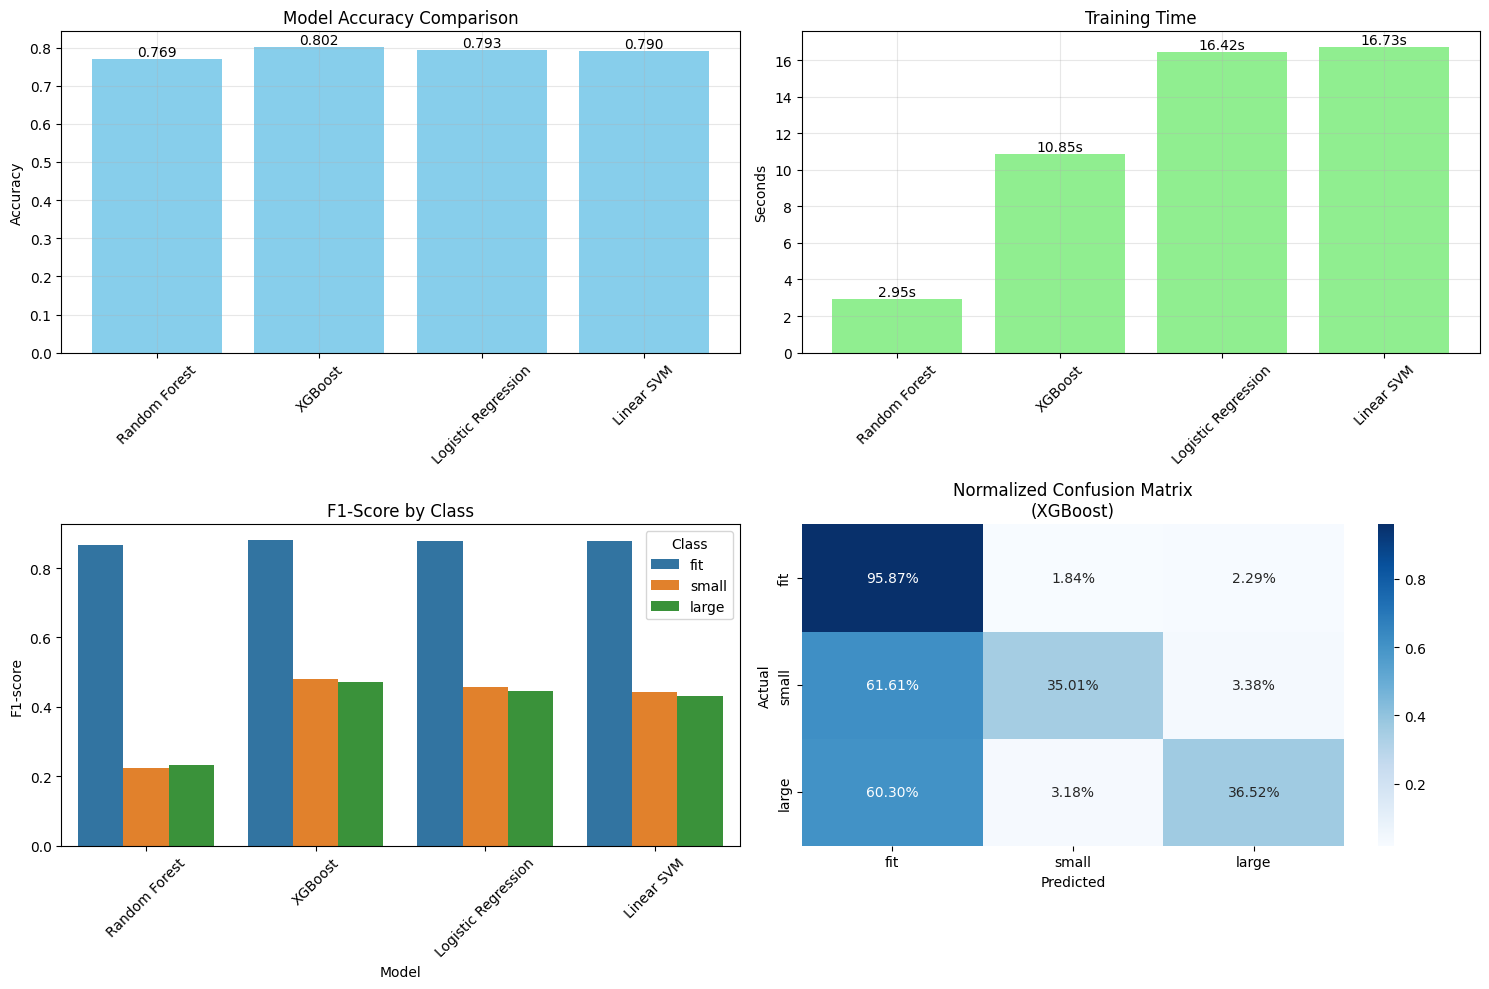

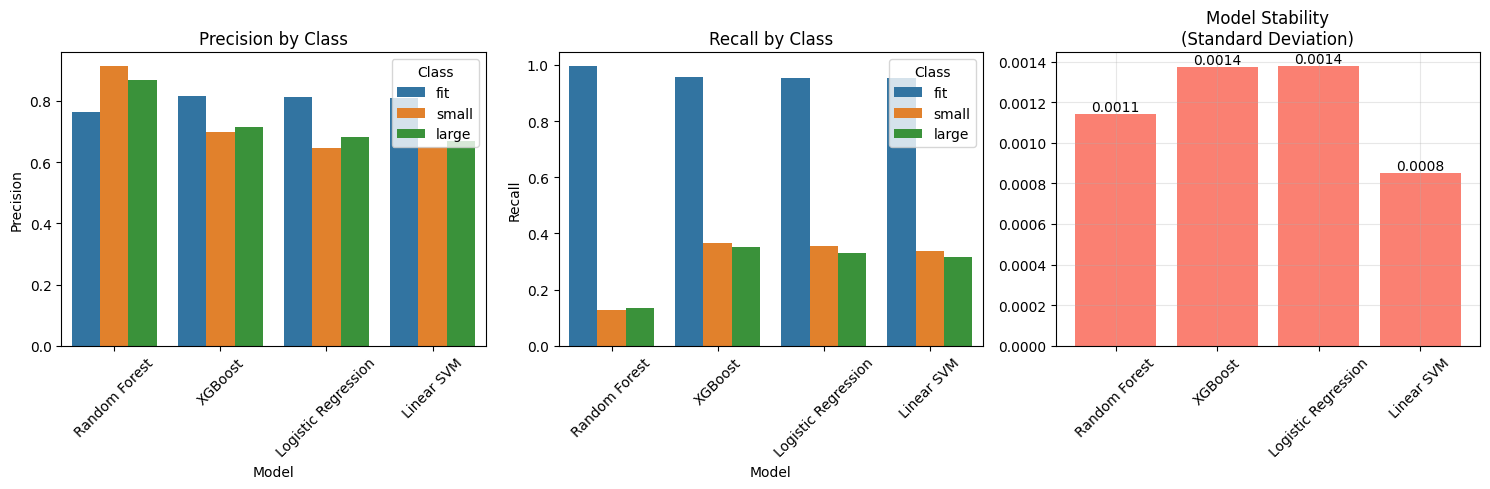

In [24]:
# Load metrics
model_files = {
    'Random Forest': 'rf_detailed_metrics.pkl',
    'XGBoost': 'xgb_detailed_metrics.pkl',
    'Logistic Regression': 'lr_detailed_metrics.pkl',
    'Linear SVM': 'svm_detailed_metrics.pkl'
}

metrics = {}
for model_name, file_path in model_files.items():
    with open(file_path, 'rb') as f:
        metrics[model_name] = pickle.load(f)

# Create figure for main performance metrics
plt.figure(figsize=(15, 10))

# Plot 1: Model Accuracy
plt.subplot(2, 2, 1)
accuracies = [m['accuracy'] for m in metrics.values()]
model_names = list(metrics.keys())

bars = plt.bar(model_names, accuracies, color='skyblue')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}',
            ha='center', va='bottom')

# Plot 2: Training Time
plt.subplot(2, 2, 2)
times = [m['training_time'] for m in metrics.values()]

bars = plt.bar(model_names, times, color='lightgreen')
plt.title('Training Time')
plt.ylabel('Seconds')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}s',
            ha='center', va='bottom')

# Plot 3: Per-Class F1 Scores
plt.subplot(2, 2, 3)
f1_scores = []
for model_name, metric in metrics.items():
    for class_name in ['fit', 'small', 'large']:
        f1_scores.append({
            'Model': model_name,
            'Class': class_name,
            'F1-score': metric['classification_report'][class_name]['f1-score']
        })

f1_df = pd.DataFrame(f1_scores)
sns.barplot(data=f1_df, x='Model', y='F1-score', hue='Class')
plt.title('F1-Score by Class')
plt.xticks(rotation=45)

# Plot 4: Best Model's Confusion Matrix
plt.subplot(2, 2, 4)
best_model = max(metrics.items(), key=lambda x: x[1]['accuracy'])[0]
conf_matrix = metrics[best_model]['confusion_matrix_normalized']

sns.heatmap(conf_matrix, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=['fit', 'small', 'large'],
            yticklabels=['fit', 'small', 'large'])
plt.title(f'Normalized Confusion Matrix\n({best_model})')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# Create figure for precision/recall metrics
plt.figure(figsize=(15, 5))

# Plot 1: Precision by Class
plt.subplot(1, 3, 1)
precision_data = []
for model_name, metric in metrics.items():
    for class_name in ['fit', 'small', 'large']:
        precision_data.append({
            'Model': model_name,
            'Class': class_name,
            'Precision': metric['classification_report'][class_name]['precision']
        })

precision_df = pd.DataFrame(precision_data)
sns.barplot(data=precision_df, x='Model', y='Precision', hue='Class')
plt.title('Precision by Class')
plt.xticks(rotation=45)

# Plot 2: Recall by Class
plt.subplot(1, 3, 2)
recall_data = []
for model_name, metric in metrics.items():
    for class_name in ['fit', 'small', 'large']:
        recall_data.append({
            'Model': model_name,
            'Class': class_name,
            'Recall': metric['classification_report'][class_name]['recall']
        })

recall_df = pd.DataFrame(recall_data)
sns.barplot(data=recall_df, x='Model', y='Recall', hue='Class')
plt.title('Recall by Class')
plt.xticks(rotation=45)

# Plot 3: Model Stability (Standard Deviation)
plt.subplot(1, 3, 3)
stds = [m['std_dev'] for m in metrics.values()]
bars = plt.bar(model_names, stds, color='salmon')
plt.title('Model Stability\n(Standard Deviation)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}',
            ha='center', va='bottom')

plt.tight_layout()
plt.show()